In [1]:
import orbipy as op
import numpy as np
import pandas as pd
from numba.core.ir import Raise
from numba.np.arrayobj import np_array
from orbipy import plotter
from orbipy.correction import border_correction, base_correction
from scipy.optimize import bisect
from matplotlib import pyplot as plt
import pickle


In [2]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1) / 61.350

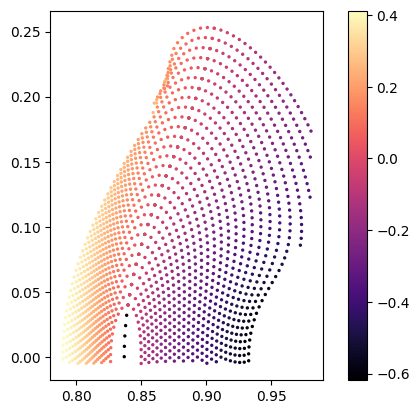

In [3]:

data_zvl = np.load('../data/contour_points/zvl/zvl_3.npy')
data_zvl = np.c_[data_zvl, np.zeros(len(data_zvl))]

with open(r"../data/contour_points/contour_points_data_6_points.pickle", "rb") as input_file:
    data = pickle.load(input_file)
data_points = []
for line in data[:58]: #40:58
    for point in line:
        data_points.append(point)
        
data_points = np.array(data_points)

# print(data_points)
plt.scatter(data_zvl[:32,0], data_zvl[:32,1], c=data_zvl[:32,2], cmap='magma', s=2)
plt.scatter(data_points[:,0], data_points[:,1], c=data_points[:,2], cmap='magma', s=2)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [4]:
class zero_correction(op.corrections.base_correction):
    def __init__(self, model, direction):
        super().__init__(model, direction)
        
    def calc_dv(self, t, s):
        return model.get_zero_state()
        

In [14]:
def generate_initial_state_map_with_sum_dv(model, data, output_data, T):
    def find_approximate_period(state):
        left = op.eventX(model.L1 - 33 * one_thousand_kms)
        right = op.eventX(model.L1 + 53 * one_thousand_kms)
        
        event = op.eventY(count=3, terminal=True)
        
        correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
        first_correction = zero_correction(model, op.unstable_direction(model))
        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=np.pi/4, events=[event], verbose=False)
        s0 = model.get_zero_state()
        
        s0[0] = state[0]
        s0[2] = state[1]
        s0[4] = state[2]
        
        try:
            df = impulse_correction.prop(0, s0, 20)
        except (RuntimeError, ValueError) as e:
            print(f"!xxxxxx! {state}, Exception: {e}")
            return np.pi/2
        
        time = impulse_correction.evout[:3,3]
        half_period = time[-1] - time[-2]
        return half_period
    
    def impulse_correction_sum_dv(state, T):
        left = op.eventX(model.L1 - 33 * one_thousand_kms)
        right = op.eventX(model.L1 + 55 * one_thousand_kms)
        
        half_period = find_approximate_period(state)
        print(f'half_period: {half_period}')
        n = int(2 * (T // half_period))
        
        correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
        first_correction = zero_correction(model, op.unstable_direction(model))
        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=half_period/2)
        s0 = model.get_zero_state()
        
        s0[0] = state[0]
        s0[2] = state[1]
        s0[4] = state[2]
        try:
            _ = impulse_correction.prop(0, s0, n)
        except (RuntimeError, ValueError) as e:
            print(f"!xxxxxx! {state}, Exception: {e}")
            return -1
        dv_norms = np.linalg.norm(impulse_correction.dvout[:,3:6], axis=1)
        return np.sum(dv_norms)
    
    
    for line in data:
        line_output = []
        for initial_sate in line:
            print(initial_sate)
            sum_dv = impulse_correction_sum_dv(initial_sate, T)
            print(f'dv sum: {sum_dv}')
            line_output.append([initial_sate, sum_dv])
        output_data.append(line_output)
        with open("../data/contour_points/sumdv_maps/sum_dv_map_1_40-58.pickle", 'wb') as handle:
            pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

In [15]:
output = []
generate_initial_state_map_with_sum_dv(model, data[40:58], output, 32)

[0.8892188932119398, 0.19101944281501468, 0.0]
half_period: 1.7926889003599427
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 
dv sum: 1.7744214521646494e-09
[0.8942019998954472, 0.1891628531070257, -0.02390845099160143]
half_period: 1.1952718776122326
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 
dv sum: 8.685302734375002e-14
[0.8988237112254762, 0.18653263221422814, -0.046251808688602555]
half_period: 0.9205163313332028
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
dv sum: 1.3140869140624997e-13
[0.90307030465814, 0.18333189452102616, -0.06710185843944395]
half_period: 1.313294507838513
Simple station-keeping: 0 1 2 3 4 5 6

[[8.89218893e-01 1.91019443e-01 1.77442145e-09]
 [8.94202000e-01 1.89162853e-01 8.68530273e-14]
 [8.98823711e-01 1.86532632e-01 1.31408691e-13]
 ...
 [8.70762527e-01 2.21507496e-01 2.00003439e-02]
 [8.67959211e-01 2.11274012e-01 4.80493284e-02]
 [8.67834382e-01 2.05957745e-01 1.28601074e-13]]


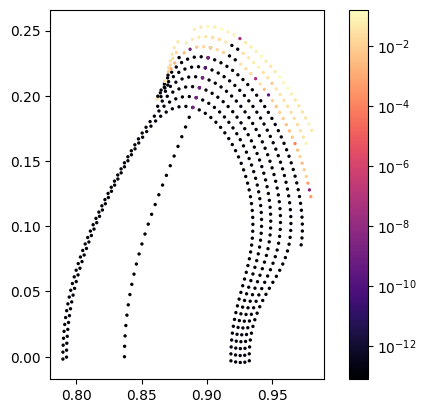

In [20]:
import matplotlib
# 
# with open(r"data/contour_points/sumdv_maps/sum_dv_map_47-50.pickle", "rb") as input_file:
#     data1 = pickle.load(input_file)
# import matplotlib
# 
# with open(r"data/contour_points/sumdv_maps/sum_dv_map_44-46_and_51.pickle", "rb") as input_file:
#     data2 = pickle.load(input_file)
#     
with open(r"../data/contour_points/sumdv_maps/sum_dv_map_1_40-58.pickle", "rb") as input_file:
    data3 = pickle.load(input_file)
    
data_zvl = np.load('../data/contour_points/zvl/zvl_3.npy')
data_zvl = np.c_[data_zvl, np.zeros(len(data_zvl))]

data_points = []
# for line in data1:
#     for point in line:
#         tmp = [*point[0][0:2], point[1]]
#         # if tmp[-1] == -1:
#         #     continue
#         # if tmp[-1] > 0.001:
#         #     continue
#         data_points.append(tmp)
#         
# for line in data2:
#     for point in line:
#         tmp = [*point[0][0:2], point[1]]
#         # if tmp[-1] == -1:
#         #     continue
#         # if tmp[-1] > 0.001:
#         #     continue
#         data_points.append(tmp)
        
for line in data3:
    for point in line:
        tmp = [*point[0][0:2], point[1]]
        if tmp[-1] == -1:
            continue
        # if tmp[-1] > 0.001:
        #     continue
        data_points.append(tmp)
        

data_points = np.array(data_points)

print(data_points)
plt.scatter(data_zvl[:32,0], data_zvl[:32,1], c=data_zvl[:32,2], cmap='magma', s=2)
plt.scatter(data_points[:, 0], data_points[:, 1], c=data_points[:, 2], cmap='magma', s=2,
            norm=matplotlib.colors.LogNorm())

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()